# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib

# Read data from csv file

In [2]:
arrhyData=pd.read_csv('Arrhythmia cleaned data.csv')

arrFilled01=arrhyData.copy()

X=arrFilled01.drop(labels=['label'],axis=1)

y=arrFilled01['label'].values

#stanardilization

scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, shuffle = True,stratify=y,random_state=42)

# LGBM Feature Selection

## 1st BayesSearchCV Optimization with LGBM + Initial data

In [3]:
gbm =LGBMClassifier(boosting_type='gbdt',objective ='multiclass',max_depth=4, num_leaves=300,
                                learning_rate=0.01,n_estimators=150)

score =cross_val_score(gbm, X_train, y_train, cv=5,scoring='neg_log_loss').mean()
print('cross validation loss at trainingset:',score) 

gbm.fit(X_train, y_train)
prob_gbm=gbm.predict_proba(X_test)
loss_gbm=log_loss(y_test,prob_gbm)
print('gbm at testset accuracy:',gbm.score(X_test,y_test)) 
print('loss at testset mannually calculated :',loss_gbm)     

cross validation loss at trainingset: -0.7990169150151226
gbm at testset accuracy: 0.75
loss at testset mannually calculated : 0.8244978254648604


In [4]:
start=datetime.now()

BayerLgbmopt = BayesSearchCV(
     gbm,
     {         
        'learning_rate': (0.005,0.01,0.015,0.02), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50
    ,cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt.fit(X_train, y_train)

stop=datetime.now()
execution_time_lgbm0=(stop-start)
print(execution_time_lgbm0)

0:02:42.959259


In [5]:
print('Best parameters found by Bayes search are:', BayerLgbmopt.best_params_)
print("val. score: %s" % BayerLgbmopt.best_score_)
print("test score: %s" % BayerLgbmopt.score(X_test, y_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 239), ('num_leaves', 170), ('subsample', 0.6450484608924866)])
val. score: -0.780576059472571
test score: -0.8141692618604046


In [6]:
lgbm=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=170,
                                learning_rate=0.01,n_estimators=239,
                                colsample_bytree= 0.8,subsample= 0.6450)

## RFE Ploting with LGBM  

In [64]:
# RFECV try the best number of features

In [116]:
start=datetime.now()
selector = RFECV(lgbm, step=1, cv=5)      
selector = selector.fit(X, y)
X_wrapper = selector.transform(X)          # Best features
score =cross_val_score(lgbm , X_wrapper, y, cv=5,scoring='neg_log_loss').mean()   # Optimal feature classification results
print(score)
print("The best numbers and rank")
print(selector.support_)                                    # selected result
print(selector.n_features_)                                 # the number of selected features
print(selector.ranking_)   

stop=datetime.now()
execution_time_lgbm=(stop-start)
print(execution_time_lgbm)

-0.7537455922722048
The best numbers and rank
[ True False  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False False  True False False False False
 False False False  True  True False False False False False False False
 False False  True  True False False False  True False False False False
 False False  True  True False False False  True False False False False
 False False  True  True  True False False  True False False False False
 False False False  True False False False  True False False False False
 False False  True  True  True  True False  True False False False False
 False False  True False  True  True False  True False False False False
 False False  True  True  True False False False False False False False
 False False  True  True  True False False  True False False False False
 False False False  True  True False False  True False False False False
 False False  True  True False False False False False False False False
 Fals

In [65]:
# RFE plotting

[1.4493588796769956, 1.3407965358978429, 1.1190945291765453, 1.0050690481678335, 0.875724305622518, 0.8330600823319069, 0.8378760750349038, 0.8346541785030809, 0.8072343899785712, 0.809026165277588, 0.8114024225458939, 0.7915733182479853, 0.7914313031576441, 0.7943352190850771, 0.7798042335241636, 0.7807148503384651, 0.7903131809568513, 0.7833185418667664, 0.7476596210893335, 0.7229908034530832, 0.7243298991377521, 0.7298197766728113, 0.7206588393745704, 0.7193647041508356, 0.7122668408374578, 0.7148734583271656, 0.7202532901593968, 0.6906199563847942, 0.6922385530594546, 0.6947705841061811, 0.6960437232516545, 0.6965542126594383, 0.6988030937969044, 0.6945762673522962, 0.6956760460604817, 0.7046061889658346, 0.7047949334352966, 0.6980638244630136, 0.705322959796464, 0.7102720886801295, 0.7048239229126902, 0.7101816091477421, 0.7019916156960844, 0.6966180465641035, 0.7015570186552503, 0.6986360532327268, 0.6956172453634141, 0.6984047198681084, 0.6941570904671639, 0.7018658970599014, 0.

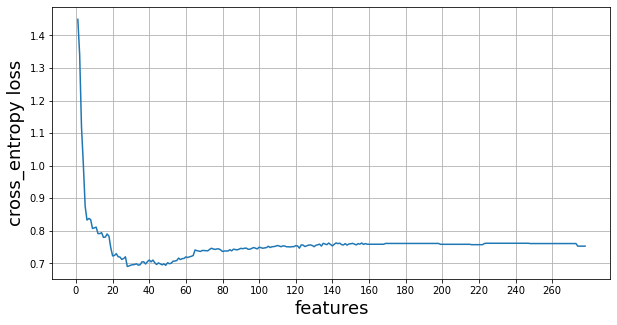

datetime.timedelta(seconds=19176, microseconds=362495)

In [8]:
start=datetime.now()
score = []                                                          
for i in range(1,279, 1):
    X_wrapper1=RFE(lgbm, n_features_to_select=i, step=1).fit_transform(X, y)      
    once = cross_val_score(lgbm, X_wrapper1, y, cv=5,scoring='neg_log_loss').mean()                    
    score.append(once)                                                          
cross_entropy_loss=[j * -1 for j in score]
# print the optimal classification result and the corresponding number of features
print(cross_entropy_loss)
print(min(cross_entropy_loss), (cross_entropy_loss.index(min(cross_entropy_loss))*1)+1)        
plt.figure(figsize=[10, 5])
plt.plot(range(1, 279, 1), cross_entropy_loss)
plt.xticks(range(0, 279, 20))
plt.xlabel(u'features', fontsize=18)
plt.ylabel(u'cross_entropy loss', fontsize=18)
plt.grid()
plt.show()
stop=datetime.now()

execution_time_lgbm1=(stop-start)
execution_time_lgbm1

In [9]:
print(min(cross_entropy_loss), (cross_entropy_loss.index(min(cross_entropy_loss))*1)+1)     

0.6906199563847942 28


In [10]:
execution_time_lgbm1

datetime.timedelta(seconds=19176, microseconds=362495)

## Explore the features after RFE ploting

In [66]:
start=datetime.now()
selector1 = RFE(lgbm, n_features_to_select=140, step=1).fit(X, y)      
print(selector1.ranking_)                                            
print(selector1.n_features_)                                         
X_wrapper_140 = selector1.transform(X)                                   

stop=datetime.now()

execution_time_lgbm2=(stop-start)
execution_time_lgbm2

[  1  18   1   1   1   1   1   1   1  30   1   1   1   1  14   1   1  45
  40   1  36  35  38  47  56  55  15   1   1  62  52  11  67  29  46  72
  76  75   1   1   5  20  65   1  99  93 113  95  33  32   1   1  77 109
 110   1 118 105 107 104  49  59   1   1   1 120  64   1  34  37  43  69
  71  68  19   1   8  89  24   1  53 121 123 125 127  54   1   1   1   1
 115   1  80  82  83  81  79  86   1   7   1   1 103   1 129 131 133 134
 136 138   1   1   1  97  61   3  66 112 111  42  31  25   1   1   1 101
  87   1  73  74  44  51  39  50  17   1   1 114 139   1 132 130 128 126
 124 122   1   1   2 108 106  10 102 100  98  96  94  92   1  16   1   1
  70  91   1   1   1   1   1   1   1   1  63  48   1   1   1   1   1   1
   1   9  85  57   1   1  13   4   1   1   1   1  60  22   1   1   1   1
   1  12   1   1  78  21   1   1   1   1   1   1   1   1  41  27   1   1
   1   1   1 135   1   1   1  90   1   1   1   1   1   1   1   1   1 117
   1   1   1   1   1   1   1   1 119 116   1   1   

datetime.timedelta(seconds=65, microseconds=832951)

In [22]:
start=datetime.now()
selector28 = RFE(lgbm, n_features_to_select=28, step=1).fit(X, y)      
print(selector28.ranking_)                                            
print(selector28.n_features_)                                         
X_wrapper_28 = selector28.transform(X)                                   

stop=datetime.now()

execution_time_lgbm2=(stop-start)
execution_time_lgbm2

[ 34 130  57   1   1  81   1   9  22 142  41   8  75   1 126  43  39 157
 152 101 148 147 150 159 168 167 127  80  76 174 164 123 179 141 158 184
 188 187   1   1 117 132 177  10 211 205 225 207 145 144  53 106 189 221
 222  68 230 217 219 216 161 171  84  49  70 232 176 105 146 149 155 181
 183 180 131  56 120 201 136  91 165 233 235 237 239 166  95  98  27 104
 227   1 192 194 195 193 191 198  42 119  87  14 215  24 241 243 245 246
 248 250   1  50  19 209 173 115 178 224 223 154 143 137 103  99  18 213
 199  65 185 186 156 163 151 162 129  12  82 226 251  38 244 242 240 238
 236 234 111  11 114 220 218 122 214 212 210 208 206 204  55 128  90  48
 182 203  54   1  86   7  40  69  66   6 175 160   1  13  71  62  45   5
  28 121 197 169  36  58 125 116  17  61  33  96 172 134  20  37  21  23
  51 124  67 109 190 133  74  85 112  92  15   1 102  83 153 139  47   1
  94  93   1 247   1 107   1 202   2  97   1  25   1  73  77   1  63 229
  44   1   3 100  59   4  26   1 231 228 108  30  8

datetime.timedelta(seconds=107, microseconds=885815)

## Save selected features to csv file after REF

In [23]:
index28=selector28.get_support(indices=True)
index28

array([  3,   4,   6,  13,  38,  39,  91, 110, 165, 174, 209, 215, 218,
       220, 222, 226, 228, 231, 235, 241, 247, 250, 255, 257, 258, 265,
       267, 275], dtype=int64)

In [28]:
idx=[  3,   4,   6,  13,  38,  39,  91, 110, 165, 174, 209, 215, 218,220, 222, 226, 228, 231, 235, 241, 247, 250, 255, 257, 258, 265, 267, 275]
A=arrFilled01.iloc[ :,idx]
A['label'] = y


In [29]:
A.to_csv('Arrhthymia selected 28 features.csv',index=False)

In [30]:
features28=pd.read_csv('Arrhthymia selected 28 features.csv')
# ,index_col=0)
features28.head()

,Weight,QRS duration,Q-T interval,Heart rate,Q wavechannel DIIII,R wavechannel DIIII,Number of intrinsic deflectionschannel V1,Q wavechannel V3,T wave,P wave DII,...,S wave V3,QRSTA V3,R wave V4,T wave V4,QRSTA V4,JJ wave V5,T wave V5,QRSTA V5,T wave V6,label
0,64,81,401,53,32,24,16,0,1.5,0.1,...,-7.7,27.7,9.5,2.6,34.6,-0.4,2.6,43.4,2.1,5
1,95,138,386,75,28,116,100,0,2.5,0.7,...,-4.1,23.3,10.0,2.2,20.7,1.3,3.4,48.2,3.4,7
2,94,100,380,71,20,52,0,0,1.9,0.4,...,-7.9,51.0,15.0,3.3,63.1,0.1,3.0,68.0,2.6,0
3,52,77,377,70,0,44,12,0,1.0,0.5,...,-11.0,21.2,7.7,1.9,15.4,0.0,1.3,18.9,1.0,0
4,54,78,376,67,0,56,8,0,1.0,0.6,...,-9.0,21.1,6.6,1.4,14.2,-0.2,0.8,20.9,0.5,0


In [31]:
arrhyData=pd.read_csv('Arrhthymia selected 28 features.csv')

arrFilled01=arrhyData.copy()

X1=arrFilled01.drop(labels=['label'],axis=1)

y1=arrFilled01['label'].values

#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset
X1_train, X1_test, y1_train, y1_test =train_test_split(X1, y1,test_size=0.20, stratify=y1,random_state=42)

In [32]:
lgbm.fit(X1_train, y1_train)

lgbm.score(X1_test, y1_test)

0.7613636363636364

# Build  OPT model for each model after RFE

## 2nd BayesSearchCV Optimization at LGBM using new features  

In [35]:
score =cross_val_score(lgbm, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
print('training loss score:',score) 

BayerLgbmopt1 = BayesSearchCV(
     lgbm,
     {         
        'learning_rate': (0.005,0.01,0.015,0.02), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50
    ,cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt1.fit(X1_train, y1_train)



lgbm.score(X1_test, y1_test)

training loss score: -0.7630947535174247


0.7613636363636364

In [36]:
print('Best parameters found by Bayes search are:', BayerLgbmopt1.best_params_)
print("val. score: %s" % BayerLgbmopt1.best_score_)
print("test score: %s" % BayerLgbmopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.015), ('max_depth', 3), ('n_estimators', 182), ('num_leaves', 113), ('subsample', 0.5)])
val. score: -0.7373100997106441
test score: -0.8024143592489122


In [71]:
lgbm1 =LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=3, num_leaves=113,
                                learning_rate=0.015,n_estimators=182,
                                colsample_bytree= 0.5,subsample= 0.5)

In [72]:

lgbm_arrhthymia=lgbm1.fit(X1_train,y1_train)

In [73]:
start=datetime.now()
lgbm1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_lgbm4='%.4f'%(stop-start).total_seconds()
print(execution_time_lgbm4)

0.3363


In [74]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.75
F1 score with LGBM is:  0.75
ROC_AUC score with LGBM is:  0.9009681809093154
Cross entropy loss score with LGBM is:  0.8024143592489122


In [75]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.7500
0.7500
0.9010
0.8024


In [76]:
start=datetime.now()
accuracy_score_24 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_24 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_24 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_24 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 20  feature:",accuracy_score_24)
print('F1 score 20  feature:',F1_score_24)
print('roc_auc 20  feature:',roc_auc_score_24)
print("cross entropy loss 20  feature:",neg_loss_score_24)


accuracy 20  feature: 0.7628571428571428
F1 score 20  feature: 0.7628571428571428
roc_auc 20  feature: 0.9239638412644581
cross entropy loss 20  feature: -0.7373100997106441


In [77]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

0.1559


In [78]:
# save the model
joblib.dump(lgbm_arrhthymia,'lgbm_arrhthymia.model')

['lgbm_arrhthymia.model']

In [79]:
rflgbm_arrhthymia=joblib.load('lgbm_arrhthymia.model')
resultlgmb=rflgbm_arrhthymia.score(X1_test,y1_test)

In [80]:
resultlgmb

0.75

## SVM -- Optimization

In [81]:
svc = SVC(random_state=42
           ,C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
accuracies = cross_val_score(svc,X1_train,y1_train,cv=5)
svc.fit(X1_train,y1_train)
svc.predict(X1_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X1_test,y1_test))

Train Score: 0.7457142857142858
Test Score: 0.7613636363636364


In [110]:
start=datetime.now()                
# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt0 = BayesSearchCV(
    SVC(probability=True, random_state=42

    ),
    {
        
       'kernel': ['linear', 'poly', 'rbf'],
        'C':(1, 10),     
        'gamma': (0.01, 1),
          'degree':(1,10)

    },
 
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt0.fit(X_train, y_train)
stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1


datetime.timedelta(seconds=54, microseconds=636006)

In [112]:
print("best params: %s" % str(BayerSvmopt0.best_params_))


print("val. score: %s" % BayerSvmopt0.best_score_)
print("test score: %s" % BayerSvmopt0.score(X_test, y_test))

best params: OrderedDict([('C', 1), ('degree', 1), ('gamma', 0.01), ('kernel', 'poly')])
val. score: -0.861362979984599
test score: -0.9546811079416215


In [114]:
svc0 = SVC(random_state=42
           ,C= 1
           ,kernel='poly'
           ,degree= 1
          ,gamma=0.01
          , probability=True)
accuracies = cross_val_score(svc0,X_train,y_train,cv=5)
svc0.fit(X_train,y_train)
svc0.predict(X_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc0.score(X_test,y_test))

Train Score: 0.72
Test Score: 0.7045454545454546


In [83]:
pred=svc.predict(X1_test)
prob=svc.predict_proba(X1_test)
print("Test loss Score:",log_loss(y1_test,prob))

Test loss Score: 0.7776483558165291


In [84]:
start=datetime.now()                
# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt = BayesSearchCV(
    SVC(probability=True, random_state=42

    ),
    {
        
       'kernel': ['linear', 'poly', 'rbf'],
        'C':(1, 10),     
        'gamma': (0.01, 1),
          'degree':(1,10)

    },
 
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt.fit(X1_train, y1_train)
stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1


datetime.timedelta(seconds=47, microseconds=726974)

In [85]:
print("best params: %s" % str(BayerSvmopt.best_params_))


print("val. score: %s" % BayerSvmopt.best_score_)
print("test score: %s" % BayerSvmopt.score(X1_test, y1_test))

best params: OrderedDict([('C', 10), ('degree', 1), ('gamma', 0.01), ('kernel', 'rbf')])
val. score: -0.790617481110975
test score: -0.8262396459877309


In [87]:
svc1=SVC(probability=True, random_state=42
          ,C=10
           ,degree= 1
           ,gamma= 0.01
           ,kernel='rbf')

In [88]:

start=datetime.now()
svc1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()
print(execution_time_svc)

svc1.score(X1_test,y1_test)

0.0468


0.7386363636363636

In [89]:
svc_arrhthymia=svc1.fit(X1_train,y1_train)

In [90]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.7485714285714286
F1 score 20  feature: 0.7485714285714286
roc_auc 20  feature: 0.9179202997835244
cross entropy loss 20  feature: -0.790617481110975


In [91]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.0351


In [92]:
y_pred_svc1=svc1.predict(X1_test)
y_prob_svc1=svc1.predict_proba(X1_test)

In [93]:

svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc1)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc1,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc1,multi_class='ovr',labels=np.unique(y1_test))
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc1)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.7386
0.7386
0.8960
0.8262


In [94]:

joblib.dump(svc_arrhthymia,'svc_arrhthymia.model')

['svc_arrhthymia.model']

In [95]:

RFsvc=joblib.load('svc_arrhthymia.model')

resultsvc=RFsvc.score(X1_test,y1_test)

In [96]:
resultsvc

0.7386363636363636

## Random Forest-- Optimization

In [97]:
rf = RFC(random_state=42)


Bayesrfopt = BayesSearchCV(
   rf,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt.fit(X_train, y_train)
print('Best parameters found by grid search are:', Bayesrfopt.best_params_)

Best parameters found by grid search are: OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('max_features', 'sqrt'), ('n_estimators', 150)])


In [98]:
print("val. score: %s" % Bayesrfopt.best_score_)
print("test score: %s" % Bayesrfopt.score(X_test, y_test))

val. score: -0.8274483515375927
test score: -0.8380054316797628


In [99]:
rf1 = RFC(random_state=42, max_features='sqrt', n_estimators= 150,
                                     max_depth=15, 
                                     criterion='gini')

In [100]:
start=datetime.now()
rf1.fit(X_train,y_train)
stop=datetime.now()
execution_time_rf=(stop-start)
execution_time_rf
training_time_rf0=execution_time_rf.total_seconds()
training_time_rf0='%.4f'%training_time_rf0
print(training_time_rf0)

0.3160


In [101]:
start=datetime.now()
Bayesrfopt1 = BayesSearchCV(
   rf1,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_rf0=(stop-start)
print(execution_time_rf0)
print('Best parameters found by grid search are:', Bayesrfopt1.best_params_)

0:01:25.588851
Best parameters found by grid search are: OrderedDict([('criterion', 'gini'), ('max_depth', 11), ('max_features', 'log2'), ('n_estimators', 150)])


In [102]:
print("val. score: %s" % Bayesrfopt1.best_score_)
print("test score: %s" % Bayesrfopt1.score(X1_test, y1_test))

val. score: -0.7538680233829647
test score: -0.7585817267570548


In [103]:
rf2= RFC(random_state=42, max_features='log2', n_estimators= 150,
                                     max_depth=11, 
                                     criterion='gini')

In [104]:
start=datetime.now()
accuracy_score_24_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_24_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_24_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_24_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 24  feature:",accuracy_score_24_rf)
print('F1 score 24  feature:',F1_score_24_rf)
print('roc_auc 24  feature:',roc_auc_score_24_rf)
print("cross entropy loss 24  feature:",neg_loss_score_24_rf)

accuracy 24  feature: 0.7628571428571428
F1 score 24  feature: 0.7628571428571429
roc_auc 24  feature: 0.9356226987870032
cross entropy loss 24  feature: -0.7538680233829647


In [105]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.2148


In [106]:
rf_arrhthymia=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)
print("Accuracy score with RF is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with RF is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with RF is: ", roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with RF is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with RF is:  0.7727272727272727
F1 score with RF is:  0.7727272727272727
ROC_AUC score with RF is:  0.9123030288427544
Cross entropy loss score with RF is:  0.7585817267570548
0.7727
0.7727
0.9123
0.7586


In [107]:
# save the model
joblib.dump(rf_arrhthymia,'rf_arrhthymia.model')

['rf_arrhthymia.model']

In [108]:
   #加载模型
RFrf=joblib.load('rf_arrhthymia.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [109]:
rfresult

0.7727272727272727